In [80]:
import argparse, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
from dgl.data import BitcoinOTC
import datetime
from dgl.nn.pytorch import GraphConv
import time
from sklearn.metrics import f1_score
import os
import json
from collections import defaultdict, Counter
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import networkx as nx
from dgl import DGLGraph
from dgl.nn.pytorch.conv import SAGEConv
import itertools
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegressionCV
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import pickle

import matplotlib.pyplot as plt

## Hyperparameters

In [3]:
num_nodes = 100386

In [4]:
out_path = '/misc/vlgscratch4/BrunaGroup/rj1408/dynamic_nn/models/twitter/lrmlp/'
data_path = '../twitter_data/public/'
activation = F.leaky_relu

In [5]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    device = 'cuda'
else:
    device = 'cpu'

## Data loading

In [6]:
def load_hate(features, edges, num_features):
    num_nodes = 100386
    num_feats = num_features
    feat_data = np.zeros((num_nodes, num_feats))
    labels = np.empty((num_nodes, 1), dtype=np.int64)
    node_map = {}
    label_map = {}

    with open(features) as fp:
        for i, line in enumerate(fp):
            info = line.strip().split()
            feat_data[i, :] = list(map(float, info[1:-1]))
            node_map[info[0]] = i
            if not info[-1] in label_map:
                label_map[info[-1]] = len(label_map)
            labels[i] = label_map[info[-1]]

    adj_lists = defaultdict(set)
    with open(edges) as fp:
        for i, line in enumerate(fp):
            info = line.strip().split()
            paper1 = node_map[info[0]]
            paper2 = node_map[info[1]]
            adj_lists[paper1].add(paper2)
            adj_lists[paper2].add(paper1)

    print(label_map)
    temp = [[[k]*len(v), list(v)] for k,v in adj_lists.items()]
    temp2 = list(zip(*temp))
    src = list(itertools.chain.from_iterable(temp2[0]))
    dst = list(itertools.chain.from_iterable(temp2[1]))
    return torch.tensor(feat_data).float(), torch.tensor(labels).int().flatten(), (src, dst)

In [7]:
feat_data, labels, adj_lists = load_hate(os.path.join(data_path, 'hate/users_hate_all.content'), os.path.join(data_path, 'hate/users.edges'), 320)
feat_data = feat_data.numpy()
labels = labels.numpy()

feat_data = feat_data[labels != 1]
labels = labels[labels != 1]
labels[labels == 2] = 1

print(feat_data.shape)
print(labels.shape)

{'normal': 0, 'other': 1, 'hateful': 2}
(4971, 320)
(4971,)


In [8]:
train_data, test_data, train_targets, test_targets = train_test_split(feat_data,
                                         labels,
                                         test_size=0.40,
                                         random_state=101)

print("Sizes and class distributions for train/test data")
print("Shape train_data {}".format(train_data.shape))
print("Shape test_data {}".format(test_data.shape))
print("Train data number of 0s {} and 1s {}".format(np.sum(train_targets==0), 
                                                    np.sum(train_targets==1)))
print("Test data number of 0s {} and 1s {}".format(np.sum(test_targets==0), 
                                                   np.sum(test_targets==1)))

Sizes and class distributions for train/test data
Shape train_data (2982, 320)
Shape test_data (1989, 320)
Train data number of 0s 2647 and 1s 335
Test data number of 0s 1780 and 1s 209


In [15]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', 
                                    standardize=True) 
normalizer = pt.fit(train_data)
train_data_norm = normalizer.transform(train_data)
test_data_norm = normalizer.transform(test_data)
train_data[:, :] = train_data_norm
test_data[:, :] = test_data_norm

In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                     np.unique(train_targets), 
                                     train_targets)
train_class_weights = dict(zip(np.unique(train_targets), 
                               class_weights))
train_class_weights

{0: 0.5632791839818663, 1: 4.450746268656716}

## Logistic Regression

In [30]:
col_sel = [0.03125,0.0625,0.125,1]
accuracy_map = {}
auc_map = {}

for num_cols in col_sel:
    all_accuracies = []
    all_aucs = []

    for iters in range(3):
        
        lr = LogisticRegressionCV(cv=5, 
                          class_weight=train_class_weights, 
                          max_iter=1000)  # Let's use the default parameters
        
        #select some random columns
        train_sub_data = train_data[:, : int(train_data.shape[1]*num_cols)]
        test_sub_data = test_data[:, : int(test_data.shape[1]*num_cols)]
        
        lr.fit(train_sub_data, train_targets.ravel())
        test_preds_lr = lr.predict_proba(test_sub_data)

        accuracy = lr.score(test_sub_data, test_targets)

        #Auc
        test_predictions_class_lr = ((test_preds_lr[:, 1]>0.5)*1).flatten()
        roc_auc_lr = metrics.roc_auc_score(test_targets, test_preds_lr[:, 1].flatten())
        all_accuracies.append(accuracy)
        all_aucs.append(roc_auc_lr)
    
    accuracy_map[num_cols] = all_accuracies
    auc_map[num_cols] = all_aucs

/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: Conver

In [32]:
accuracy_thresh = list(map(lambda kvp: np.mean(kvp[1]), accuracy_map.items()))
auc_thresh = list(map(lambda kvp: np.mean(kvp[1]), auc_map.items()))
print("Accuracies: ", accuracy_thresh)
print("Aucs: ", auc_thresh)

Accuracies:  [0.7285067873303167, 0.7616892911010558, 0.8190045248868779, 0.8506787330316742]
Aucs:  [0.7796785119079619, 0.8351190796193753, 0.8784957797967851, 0.8900704263211656]


<BarContainer object of 4 artists>

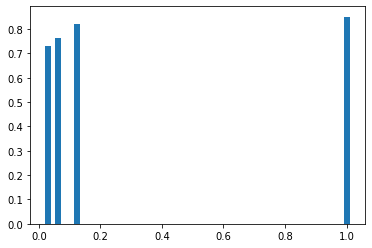

In [43]:
plt.bar(col_sel, accuracy_thresh, width = 0.02)

<BarContainer object of 4 artists>

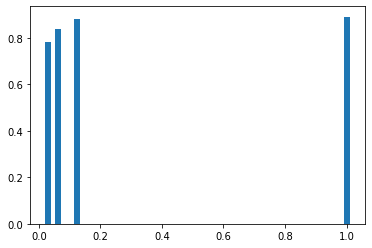

In [44]:
plt.bar(col_sel, auc_thresh, width = 0.02)

# MLP

In [45]:
hidden_size = 128
n_layers = 1
drpout = 0
wtdecay = 0

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

In [51]:
class UserDataset(Dataset):
    
    def __init__(self, np_df, label_nparray):
        super().__init__()
        self.np_df = np_df
        self.labels = label_nparray
            
    def __getitem__(self, i):
        return torch.from_numpy(self.np_df[i]).float(), self.labels[i]
    
    def __len__(self):
        return self.np_df.shape[0]

In [52]:
def predict(model, device, val_loader):
    model.eval()
    for batch_num, (inputs, _) in enumerate(val_loader):
        inputs = inputs.to(device)
        logits = model(inputs).view(-1)
        
        if batch_num == 0:
            all_logits = logits
        else:
            all_logits = torch.cat((all_logits, logits))
    return all_logits

In [53]:
#Code for supervised training
def train_model(model, dataloaders, criterion, optimizer, scheduler, device, checkpoint_path, f, verbIter, hyperparams, num_epochs=25):
    metrics_dict = {}
    metrics_dict["train"] = {}
    metrics_dict["valid"] = {}
    metrics_dict["train"]["loss"] = {}
    metrics_dict["train"]["loss"]["epochwise"] = []
    metrics_dict["train"]["loss"]["stepwise"] = []
    metrics_dict["valid"]["loss"] = {}
    metrics_dict["valid"]["loss"]["epochwise"] = []
    metrics_dict["valid"]["loss"]["stepwise"] = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 9999999999999999

    for epoch in range(num_epochs):
        f.write('Epoch {}/{} \n'.format(epoch, num_epochs - 1))
        f.write('-' * 10)
        f.write('\n')
        f.flush()

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            n_samples = 0
            
            # Iterate over data.
            for batch_num, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.float().to(device)
                                
                # zero the parameter gradients
                optimizer.zero_grad()
                batchSize = inputs.size(0)
                n_samples += batchSize
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.view(-1,1))
                    
                    # statistics
                    running_loss += loss.item()
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                if batch_num % verbIter == 0:
                    # Metrics
                    epoch_loss = running_loss /n_samples

                    f.write('{} Loss: {:.4f} \n'.format(phase, epoch_loss))
                    f.flush()
                    
                    metrics_dict[phase]["loss"]["stepwise"].append(epoch_loss)
                
            # Metrics
            epoch_loss = running_loss /n_samples

            f.write('{} Loss: {:.4f} \n'.format(phase, epoch_loss))
            f.flush()
            
            metrics_dict[phase]["loss"]["epochwise"].append(epoch_loss)
            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'full_metrics': metrics_dict,
            'hyperparams': hyperparams
            }, '%s/net_epoch_%d.pth' % (checkpoint_path, epoch))

    f.write('Best val loss: {:4f} \n'.format(best_loss))
    f.flush()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [54]:
class MLP(nn.Module):
    def __init__(self,
                 inp_size,
                 mlp_hidden,
                 n_layers,
                 dropout):
        super(MLP, self).__init__()
        self.distrlayer = nn.Linear(inp_size, mlp_hidden)
        self.layers = nn.ModuleList()
        # hidden layers
        for i in range(n_layers):
            self.layers.append(nn.Linear(mlp_hidden, mlp_hidden))
        # output layer
        self.nonlinear = nn.ReLU()
        self.outlayer = nn.Linear(mlp_hidden, 1)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, features):
        h = self.distrlayer(features)
        h = self.nonlinear(h)
        h = self.dropout(h)
        for i, layer in enumerate(self.layers):
            h = layer(h)
            h = self.nonlinear(h)
            h = self.dropout(h)
        h = self.outlayer(h)
        return h

In [55]:
neg_ex = train_data.shape[0] - np.sum(train_targets)
pos_ex = np.sum(train_targets)
imbalance_factor = neg_ex/pos_ex

In [60]:
col_sel = [0.03125,0.0625,0.125,1]
model_dir = '/misc/vlgscratch4/BrunaGroup/rj1408/dynamic_nn/models/static_gcn/twitter/mlp/128hid/'
bstmodel_dict = {}

for num_cols in col_sel:
    model_out_dir = os.path.join(model_dir, str(num_cols))
    
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    
    col_numbers = int(train_data.shape[1]*num_cols)
    train_dataset = UserDataset(train_data[:, :col_numbers], train_targets)
    test_dataset = UserDataset(test_data[:, :col_numbers], test_targets)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    dataloaders = {}
    dataloaders["train"] = train_loader
    dataloaders["valid"] = test_loader
    allmodels = []
    
    for iterations in range(5):
        model = MLP(col_numbers, hidden_size, n_layers, drpout)
        model.to(current_device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([imbalance_factor])).to(current_device) #pos_weight=torch.FloatTensor([train_class_weights[1]])
        model_parameters = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.Adam(model_parameters, lr=0.001, weight_decay = wtdecay)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        f = open(os.path.join(model_out_dir,'training_logs.txt'), 'w+')
        options = {
            "n_layers":n_layers,
            "mlp_size":hidden_size
        }
        bst_model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, current_device, model_out_dir, f, 10, options, 15)
        allmodels.append(bst_model)
        
    bstmodel_dict[num_cols] = allmodels

/home/rj1408/anaconda3/envs/dgl_env/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [70]:
all_aucs_mean = []
all_aucs_std = []
all_accs_mean = []
all_accs_std = []
precat20_mean = []
precat20_std = []
precat40_mean = []
precat40_std = []
precat60_mean = []
precat60_std = []

for num_cols in col_sel:
    col_numbers = int(train_data.shape[1]*num_cols)
    test_dataset = UserDataset(test_data[:, :col_numbers], test_targets)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    all_aucs = []
    all_accs = []
    precat20 = []
    precat40 = []
    precat60 = []
    
    for bstmodel in bstmodel_dict[num_cols]:
        predictions_logits = predict(bstmodel, current_device, test_loader)
        sigLayer = nn.Sigmoid()
        predictions_scores = sigLayer(predictions_logits).cpu().detach().numpy()
        targets = test_targets
        roc_auc_mlp = metrics.roc_auc_score(targets, predictions_scores)
        accuracy = getaccuracy(targets, predictions_logits)
        all_aucs.append(roc_auc_mlp)
        all_accs.append(accuracy)
        precat20.append(precisionk(20, targets, predictions_logits))
        precat40.append(precisionk(40, targets, predictions_logits))
        precat60.append(precisionk(60, targets, predictions_logits))
    all_aucs_mean.append(np.mean(all_aucs))
    all_aucs_std.append(np.std(all_aucs))
    all_accs_mean.append(np.mean(all_accs))
    all_accs_std.append(np.std(all_accs))
    precat20_mean.append(np.mean(precat20))
    precat20_std.append(np.std(precat20))
    precat40_mean.append(np.mean(precat40))
    precat40_std.append(np.std(precat40))
    precat60_mean.append(np.mean(precat60))
    precat60_std.append(np.std(precat60))

In [71]:
all_aucs_mean, all_aucs_std

([0.7924326649104886,
  0.853418633406806,
  0.8836008816730283,
  0.901584323423472],
 [0.002149276884496393,
  0.0010445944731390583,
  0.001198723335805517,
  0.004369468770778662])

In [64]:
def getaccuracy(labels, logits):
    predictions = (logits > 0).long()
    predictions = predictions.cpu().detach().numpy()
    correct =  np.sum(predictions == labels)
    total = labels.shape[0]
    return correct/total

In [67]:
all_accs_mean, all_accs_std

([0.7435897435897436,
  0.7902463549522373,
  0.8128707893413776,
  0.8347913524384112],
 [0.004359875995712161,
  0.012708727058509228,
  0.021059561736065793,
  0.010207991073472483])

In [69]:
def precisionk(k, labels, logits):
    logits = logits.cpu().detach().numpy()
    zpped = list(zip(labels, logits))
    zpped = sorted(zpped, key= lambda kvp: kvp[1], reverse=True)
    zpped = zpped[:k]
    tps = len(list(filter(lambda kvp: kvp[0] == 1, zpped)))
    return tps/k

In [74]:
precat60_mean, precat60_std

([0.57, 0.5566666666666666, 0.68, 0.7333333333333334],
 [0.02211083193570267,
  0.022607766610417544,
  0.02449489742783178,
  0.027888667551135886])

In [81]:
metrics_dir = '/misc/vlgscratch4/BrunaGroup/rj1408/dynamic_nn/models/static_gcn/twitter/mlp/128hid/'
metrics_dict = {}
for i, num_cols in enumerate(col_sel):
    metrics_dict[num_cols] = {}
    metrics_dict[num_cols]['lr'] = {}
    metrics_dict[num_cols]['mlp'] = {}
    metrics_dict[num_cols]['mlp']['mean_auc'] = all_aucs_mean[i]
    metrics_dict[num_cols]['mlp']['std_auc'] = all_aucs_std[i]
    metrics_dict[num_cols]['mlp']['mean_acc'] = all_accs_mean[i]
    metrics_dict[num_cols]['mlp']['std_acc'] = all_accs_std[i]
    
    metrics_dict[num_cols]['lr']['mean_auc'] = auc_thresh[i]
    metrics_dict[num_cols]['lr']['mean_acc'] = accuracy_thresh[i]

metrics_file = '/misc/vlgscratch4/BrunaGroup/rj1408/dynamic_nn/models/static_gcn/twitter/full_metrics.pkl'
with open(metrics_file, 'wb') as f:
    pickle.dump(metrics_file, f)

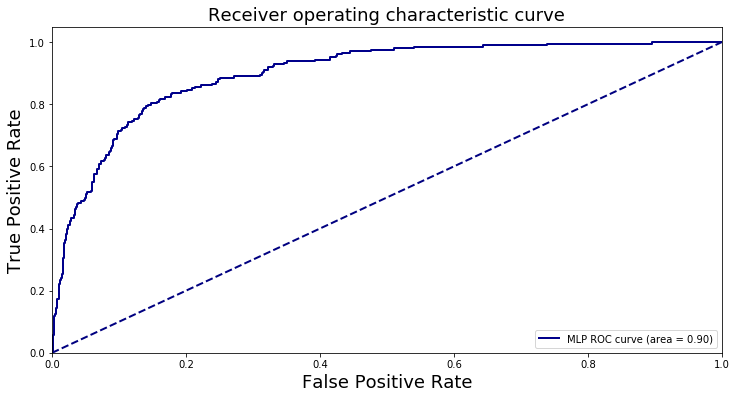

In [151]:
fpr_mlp, tpr_mlp, thresholds_mlp = metrics.roc_curve(targets, predictions_scores, pos_label=1)
plt.figure(figsize=(12,6,))
lw = 2

plt.plot(fpr_mlp, tpr_mlp, color='darkblue',
         lw=lw, label='MLP ROC curve (area = %0.2f)' % roc_auc_mlp)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic curve', fontsize=18)
plt.legend(loc="lower right")
plt.savefig("/home/rj1408/dgnn/roc_mlp.png")
plt.show()